In [1]:
# importing packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# reading in CSV
df = pd.read_csv('creditcard.csv')
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
220821,142313.0,2.228370,-1.480047,-1.875627,-1.777910,-0.549483,-0.428852,-0.635462,-0.225445,-1.665705,...,-0.287575,-0.532184,0.042820,-1.136561,-0.002225,-0.195530,-0.039929,-0.070095,84.99,0
174274,121846.0,1.935030,0.573142,-0.904663,3.502975,0.898790,0.647228,0.111386,0.051637,-1.256962,...,0.167848,0.550296,0.057251,0.359922,0.173700,0.063507,-0.038921,-0.056773,0.00,0
136833,81892.0,-0.957640,0.866259,1.690685,-0.242409,0.069591,-0.387829,0.454028,-0.153593,-0.488368,...,0.009150,0.030008,-0.133822,0.176217,-0.040002,1.135290,-0.375523,0.062362,3.84,0
170388,120156.0,0.935988,-1.471801,-3.120871,0.725920,1.108254,1.298939,0.600813,0.226943,0.532865,...,0.211974,-0.184652,-0.357264,-1.091420,-0.127987,-0.266858,-0.035785,0.060734,510.36,0
264233,161327.0,-0.252903,1.086682,-0.394310,-0.717875,0.440427,-0.730572,0.677892,0.258984,-0.180641,...,-0.261435,-0.712290,0.052698,-0.721858,-0.357179,0.186786,0.118245,0.028695,12.98,0


In [17]:
df = df.drop('Time', axis=1)

In [8]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import math
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

class modelpipeline:
    def __init__(self):
        pass
    
    def run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV):
        varlist.append(response)
        df = df[varlist]
        if standardize == True:
            df = self.standardize(df)
        if sampletype == 'smote':
            X_train, X_test, y_train, y_test = sampling.smote_oversample(df, testratio, response)
        elif sampletype == 'adasyn':
            X_train, X_test, y_train, y_test = sampling.adasyn_oversample(df, testratio, response)
        else:
            X_train, X_test, y_train, y_test = sampling.naive_oversample(df, testratio, response)
        store = self.build_model(X_train, X_test, y_train, y_test, text, modelname, CV)
        # test model with all actual fraud results
        store['actual_accuracy'] = evaluate.actual_acc(df, store['model'], response)
        return store
    
    def build_model(self, X_train, X_test, y_train, y_test, text, modelname, CV):
        if modelname == 'LogisticRegression':
            if CV == True:
                param_grid = dict(C=[0.8,1,1.2], max_iter=[300], solver=['liblinear'])
                LogRegression = LogisticRegression()
                model = GridSearchCV(LogRegression, param_grid, cv=5, scoring='f1', verbose=10)
                model.fit(X_train,y_train)
                print("Best f1 score: " + str(model.best_score_))
                print("Best parameters: " + str(model.best_params_))
            else:
                model = LogisticRegression(max_iter=300, C=0.8, solver='liblinear')
                model.fit(X_train,y_train)
        elif modelname == 'XGBoost':
            if CV == True:
                end_value = math.ceil(math.sqrt(X_train.shape[1]))
                start_value = end_value - 2       
                # treedepth = list(range(start_value, end_value+1, 2))
                param_grid = dict(n_estimators=[100], max_depth=[end_value])
                GradientBoost = GradientBoostingClassifier()
                model = GridSearchCV(GradientBoost, param_grid, cv=5, scoring='f1', verbose=10)
                model.fit(X_train,y_train)
                print("Best f1 score: " + str(model.best_score_))
                print("Best parameters: " + str(model.best_params_))
                
                # Testing out xgb.cv (incomplete)
                # model = xgb.XGBClassifier(seed=42, nthread=1, max_depth=start_value, n_estimators=100, random_state=42)
                # xgb_param = dict(n_estimators=100, max_depth=end_value)
                # xgtrain = xgb.DMatrix(X_train, label=y_train)
                # model = xgb.cv(params=xgb_param, dtrain=xgtrain, nfold=5, metrics='auc')
                # model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=5)
                
                # USING kfold library to do kfold testing on XGBoost:
                # cross_val_score using kfold does not fit the model, so nothing can be predicted
                # it's just to see the results but the model has to be fitted later on
                # kfold = KFold(n_splits=3, random_state=42)
                # print(kfold)
                # scores = cross_val_score(model, X_train, y_train, cv=kfold)
                # print("CV Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))
            else:
                model = xgb.XGBClassifier(seed=42, nthread=1, max_depth=math.ceil(math.sqrt(X_train.shape[1])),
                                          n_estimators=100, random_state=42)
                model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=5)
        elif modelname == 'RandomForest':
            if CV == True:
                start_value = math.ceil(math.sqrt(X_train.shape[1]))
                end_value = start_value + 11         
                treedepth = list(range(start_value, end_value, 5))
                param_grid = dict(random_state=[42], max_depth=treedepth, n_estimators=[100,150])
                RFC = RandomForestClassifier()
                model = GridSearchCV(RFC, param_grid, cv=5, scoring='f1', verbose=10)
                model.fit(X_train,y_train)
                print("Best f1 score: " + str(model.best_score_))
                print("Best parameters: " + str(model.best_params_))
            else:
                treedepth = math.ceil(math.sqrt(X_train.shape[1]))
                model = RandomForestClassifier(random_state=42, max_depth=treedepth, n_estimators=150)
                model.fit(X_train,y_train)
        else:
            # Parameters based on gridsearchcv of modelname = logistic regresion
            # Leave parameter blank for modelname to run this instance of logistic regression
            model = LogisticRegression(C=0.8, max_iter=300, solver='liblinear')
            model.fit(X_train,y_train)
        
        y_predict = model.predict(X_test)
        results = evaluate.model_results(y_test, y_predict, text)
        store = {"model": model, "X_train": X_train, "X_test": X_test, "y_train": y_train, 
                 "y_test": y_test, "results": results}
        print("Model fitting and results are complete!")
        return store
    
    def standardize(self, df):
        # Variables already standardized except for Amount
        # columns = df.columns.values.tolist()
        # columns.remove(response)
        for column in ['Amount']:
            df[column] = (df[column] - df[column].mean()) / df[column].std()
        return df

class sampling:
    def __init__(self):
        pass
    @staticmethod
    def naive_oversample(df, testratio, response):
        X = df.drop([response], axis=1)
        y = df[response]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=41)
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Oversampling is complete!")
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def smote_oversample(df, testratio, response):
        X = df.drop([response], axis=1)
        y = df[response]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=41)
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for SMOTE:")
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def adasyn_oversample(df, testratio, response):
        X = df.drop([response], axis=1)
        y = df[response]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=41)
        X_train, y_train = ADASYN().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for ADASYN:")
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
        return X_train, X_test, y_train, y_test



class evaluate:
    def __init__(self):
        pass
    
    @staticmethod
    def model_results(y_test, y_predict, text):
        cm = metrics.confusion_matrix(y_test, y_predict)
        print(cm)
        RFC_CM = pd.DataFrame(cm, ['Actual 0', 'Actual 1'], ['Predict 0', 'Predict 1'])
        sns.heatmap(RFC_CM, annot=True, annot_kws={"size": 16}, cmap='Greens', linewidths=1, fmt='g')# font size
        sns.set(font_scale=1.4)#for label size
        plt.title("Confusion Matrix for " + text)

        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = plt.ylim() 
        b += 0.5 
        t -= 0.5 
        plt.ylim(b, t) 
        plt.show() 

        accuracy = metrics.accuracy_score(y_test, y_predict)
        print('Accuracy: ' + str(accuracy))
        sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])
        recall = sensitivity
        print('Sensitivity: ' + str(sensitivity))
        specificity = cm[0][0] / (cm[0][0] + cm[0][1])
        print('Specificity: ' + str(specificity))
        precision = cm[1][1] / (cm[1][1] + cm[0][1])
        print('Precision: ' + str(precision))
        f1 = 2 * (recall * precision)/(recall + precision)
        print('f1 score: ' + str(f1))
        auc = evaluate.ROC(y_test, y_predict, text)
        results = {"accuracy": accuracy, "sensitivity": sensitivity, "specificity": specificity, 
                   "precision": precision, "f1": f1, "auc": auc}
        print("Model classification metrics have finished calculating!")
        return results
    
    @staticmethod
    def ROC(y_test, y_predict, text):
        # IMPORTANT: first argument is true values, second argument is predicted probabilities
        auc = metrics.roc_auc_score(y_test, y_predict)
        print("AUC value is: " + str(auc))
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
        plt.plot(fpr, tpr)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC curve for ' + text)
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.grid(True)
        return auc

    @staticmethod
    def actual_acc(df, model, response):
        allpositive = df[df[response] == 1].copy()
        x_positive = allpositive.drop([response], axis=1)
        y_positive = allpositive[response]
        # Convert to numpy array due to XGBoost model.predict not working well for pandas
        x_positive = x_positive.values
        y_positive = y_positive.values
        y_pospredict = model.predict(x_positive)
        accuracy_positive = metrics.accuracy_score(y_positive, y_pospredict)
        print("Accuracy with all fraud results is " + str(accuracy_positive * 100) + "%")
        return accuracy_positive

In [9]:
modelpipeline = modelpipeline()

In [155]:
X_train, X_test, y_train, y_test = sampling.smote_oversample(df,0.2,'Class')

Number of Xs and Ys for SMOTE:
[(0, 227451), (1, 227451)]
Oversampling is complete!


In [43]:
y_train.sum()

227451

In [44]:
y_test.sum()

98

In [26]:
colnames = list(df.columns.values)
colnames.remove('Class')
print(colnames)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [21]:
import statsmodels.discrete.discrete_model as sm

# Testing some functions and tricks

In [6]:
for colname in df.columns.values:
    print(colname)

V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
Amount
Class


In [29]:
X_train.shape

(454902, 29)

In [31]:
X_train[:,0:]

array([[ 1.95504092e+00, -3.80782711e-01, -3.15012853e-01, ...,
         4.51682478e-02, -4.71447917e-02,  9.99000000e+00],
       [-4.00975239e-01, -6.26942769e-01,  1.55533881e+00, ...,
        -3.70468822e-01, -1.44791686e-01,  4.59000000e+01],
       [ 7.25090164e-02,  8.20565650e-01, -5.61350916e-01, ...,
         2.06394866e-01,  7.02877702e-02,  1.19900000e+01],
       ...,
       [-1.46122738e+00, -6.84733284e-01,  7.78663606e-01, ...,
        -9.51184036e-02,  4.24592502e-02,  3.56509132e+02],
       [-1.18327079e+00, -8.26128280e-02,  1.89729819e+00, ...,
         5.95769488e-02, -3.16624987e-01,  4.44247638e+01],
       [-4.66966201e+00,  9.11443019e-01, -5.35063863e+00, ...,
         7.23760311e-01, -7.81816552e-01,  4.18268030e+01]])

In [39]:
X_train.shape

(454902, 29)

In [69]:
full_x = np.empty((454902,1))
np.concatenate((full_x, X_train), axis=1)

array([[ 0.00000000e+00,  1.95504092e+00, -3.80782711e-01, ...,
         4.51682478e-02, -4.71447917e-02,  9.99000000e+00],
       [ 0.00000000e+00, -4.00975239e-01, -6.26942769e-01, ...,
        -3.70468822e-01, -1.44791686e-01,  4.59000000e+01],
       [ 0.00000000e+00,  7.25090164e-02,  8.20565650e-01, ...,
         2.06394866e-01,  7.02877702e-02,  1.19900000e+01],
       ...,
       [ 0.00000000e+00, -1.46122738e+00, -6.84733284e-01, ...,
        -9.51184036e-02,  4.24592502e-02,  3.56509132e+02],
       [ 0.00000000e+00, -1.18327079e+00, -8.26128280e-02, ...,
         5.95769488e-02, -3.16624987e-01,  4.44247638e+01],
       [ 0.00000000e+00, -4.66966201e+00,  9.11443019e-01, ...,
         7.23760311e-01, -7.81816552e-01,  4.18268030e+01]])

In [124]:
# Finding element of dictionary with max value
import operator
stats = {"a":1, "b":2, "c":1000}
print(max(stats.items(), key=operator.itemgetter(1)))
print(max(stats.items(), key=operator.itemgetter(1))[0])
print(max(stats.items(), key=operator.itemgetter(1))[1])

('c', 1000)
c
1000


In [103]:
np.zeros((1,1)).any()

False

In [107]:
np.array(False).any()

False

# Actual implementation of forward selection

In [125]:
import operator
import statsmodels.discrete.discrete_model as sm

# Column names have Time (irrelevant feature) and Class (response) removed
colnames = list(df.columns.values)
colnames.remove('Class')
print(colnames)

# Total features to select = k
# In each iteration, the current set of n features is concatenated with a new feature not inside current set
# It is then sent for training with the logistic regression
# The model performance for each feature + current features is evaluated by its highest p value (worst feature)
# All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
# Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
# Set significance level, which is compared to the lowest p value of the best model in the current training iteration
# If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
# Because all the different models are worse or equally bad as the current best model, we can terminate selection process
# If not, repeat this iteration with now n+1 features and k-n-1 iterations
sig_level = 0.05

maxcolsnum = X_train.shape[1]
full_x = np.array(False)
allowed_nums = list(range(maxcolsnum))
actual_nums = []
actual_vars = []
terminate_early = False
y = y_train
for i in range(maxcolsnum):
    # Reset boolean and pval_list
    terminate_early = False
    pval_list = {}
    for j in range(maxcolsnum):
        if j in allowed_nums:
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,j].reshape(-1,1)
            print("i is " + str(i))
            print("j is " + str(j))
            print("Jth_x:")
            print(jth_x.shape)
            print("Full_x:")
            print(full_x.shape)
            print(full_x.any())
            if full_x.any():
                iter_x = np.concatenate((full_x, jth_x), axis=1)
            else:
                iter_x = jth_x
            regressor_OLS = sm.Logit(y_train, iter_x).fit()
            # print("p value for column number: " + str(i))
            # print(regressor_OLS.pvalues[0])
            pval_list[j] = max(regressor_OLS.pvalues)
            # Special condition where all the features have p values of 0, directly use these variables for training
            if max(regressor_OLS.pvalues) == 0:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums.remove(j)
                    actual_nums.append(j)
                    print("Features all have p value of 0, using feature number " + str(j))
                else:
                    full_x = jth_x
                    allowed_nums.remove(j)
                    actual_nums.append(j)
                    print("First model trained using feature number " + str(j) + " with p value of 0")
                    print("Full X:")
                    print(full_x.shape)
                terminate_early = True
                break
        else:
            continue
    if i > 0 and terminate_early == False:
        print("Getting new model with min p-values with " + str(len(actual_nums)) + " variables.")
        max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
        max_pval = pval_list[max_pval_col]
        # Need to reshape to single column instead of a long array for concating properly
        jth_x = X_train[:,max_pval_col].reshape(-1,1)
        if max_pval < sig_level:
            if full_x.any():
                full_x = np.concatenate((full_x, jth_x), axis=1)
                allowed_nums.remove(max_pval_col)
                actual_nums.append(max_pval_col)
                print("New model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
            else:
                full_x = jth_x
                allowed_nums.remove(max_pval_col)
                actual_nums.append(max_pval_col)
                print("First model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
        else:
            print("TERMINATING AS best model trained using feature number " + str(max_pval_col) + " with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
            break
                


for k in actual_nums:
    actual_vars.append(colnames[k])
print(actual_vars)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
False
i is 0
j is 0
Jth_x:
(454902, 1)
Full_x:
()
False
Optimization terminated successfully.
         Current function value: 0.575323
         Iterations 7
First model trained using feature number 0 with p value of 0
Full X:
(454902, 1)
i is 1
j is 1
Jth_x:
(454902, 1)
Full_x:
(454902, 1)
True
Optimization terminated successfully.
         Current function value: 0.511706
         Iterations 7
Features all have p value of 0, using feature number 1
i is 2
j is 2
Jth_x:
(454902, 1)
Full_x:
(454902, 2)
True
Optimization terminated successfully.
         Current function value: 0.449435
         Iterations 8
Features all have p value of 0, using feature number 2
i is 3
j is 3
Jth_x:
(454902, 1)
Full_x:
(454902, 3)
True
Optimization terminated successfully.
         Current function value: 0.42

i is 7
j is 20
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408473
         Iterations 9
i is 7
j is 21
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408965
         Iterations 9
i is 7
j is 22
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408867
         Iterations 9
i is 7
j is 23
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 9
i is 7
j is 24
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408683
         Iterations 9
i is 7
j is 25
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408863
         Iterations 9
i is 7
j is 26
Jth_x:
(454902, 1)


Optimization terminated successfully.
         Current function value: 0.189341
         Iterations 14
i is 20
j is 17
Jth_x:
(454902, 1)
Full_x:
(454902, 20)
True
Optimization terminated successfully.
         Current function value: 0.187372
         Iterations 16
i is 20
j is 21
Jth_x:
(454902, 1)
Full_x:
(454902, 20)
True
Optimization terminated successfully.
         Current function value: 0.185437
         Iterations 14
Features all have p value of 0, using feature number 21
i is 21
j is 12
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.185402
         Iterations 14
i is 21
j is 14
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.185420
         Iterations 14
i is 21
j is 17
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.183687
         Iterations 15
i is 21
j is 23
Jth_x

# Basic forward selection with a dataframe but not in a function

In [130]:
import operator
import statsmodels.discrete.discrete_model as sm

# Column names have Time (irrelevant feature) and Class (response) removed
colnames = list(df.columns.values)
colnames.remove('Class')
print(colnames)

# Total features to select = k
# In each iteration, the current set of n features is concatenated with a new feature not inside current set
# It is then sent for training with the logistic regression
# The model performance for each feature + current features is evaluated by its highest p value (worst feature)
# All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
# Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
# Set significance level, which is compared to the lowest p value of the best model in the current training iteration
# If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
# Because all the different models are worse or equally bad as the current best model, we can terminate selection process
# If not, repeat this iteration with now n+1 features and k-n-1 iterations
sig_level = 0.05

maxcolsnum = X_train.shape[1]
full_x = np.array(False)
allowed_nums = {}
for i in range(maxcolsnum):
    allowed_nums[i] = True
actual_nums = []
actual_vars = []
terminate_early = False
y = y_train
for i in range(maxcolsnum):
    # Reset boolean and pval_list
    terminate_early = False
    pval_list = {}
    for j in range(maxcolsnum):
        if allowed_nums[j] == True:
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,j].reshape(-1,1)
            print("i is " + str(i))
            print("j is " + str(j))
            print("Jth_x:")
            print(jth_x.shape)
            print("Full_x:")
            print(full_x.shape)
            print(full_x.any())
            if full_x.any():
                iter_x = np.concatenate((full_x, jth_x), axis=1)
            else:
                iter_x = jth_x
            regressor_OLS = sm.Logit(y_train, iter_x).fit()
            # print("p value for column number: " + str(i))
            # print(regressor_OLS.pvalues[0])
            pval_list[j] = max(regressor_OLS.pvalues)
            # Special condition where all the features have p values of 0, directly use these variables for training
            if max(regressor_OLS.pvalues) == 0:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums[j] = False
                    actual_nums.append(j)
                    print("Features all have p value of 0, using feature number " + str(j))
                else:
                    full_x = jth_x
                    allowed_nums[j] = False
                    actual_nums.append(j)
                    print("First model trained using feature number " + str(j) + " with p value of 0")
                    print("Full X:")
                    print(full_x.shape)
                terminate_early = True
                break
        else:
            continue
    if i > 0 and terminate_early == False:
        print("Getting new model with min p-values with " + str(len(actual_nums)) + " variables.")
        max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
        max_pval = pval_list[max_pval_col]
        # Need to reshape to single column instead of a long array for concating properly
        jth_x = X_train[:,max_pval_col].reshape(-1,1)
        if max_pval < sig_level:
            if full_x.any():
                full_x = np.concatenate((full_x, jth_x), axis=1)
                allowed_nums[max_pval_col] = False
                actual_nums.append(max_pval_col)
                print("New model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
            else:
                full_x = jth_x
                allowed_nums[max_pval_col] = False
                actual_nums.append(max_pval_col)
                print("First model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
        else:
            print("TERMINATING AS best model trained using feature number " + str(max_pval_col) + " with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
            break
                

for k in actual_nums:
    actual_vars.append(colnames[k])
print('Final variables selected:')
print(actual_vars)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
i is 0
j is 0
Jth_x:
(454902, 1)
Full_x:
()
False
Optimization terminated successfully.
         Current function value: 0.575323
         Iterations 7
First model trained using feature number 0 with p value of 0
Full X:
(454902, 1)
i is 1
j is 1
Jth_x:
(454902, 1)
Full_x:
(454902, 1)
True
Optimization terminated successfully.
         Current function value: 0.511706
         Iterations 7
Features all have p value of 0, using feature number 1
i is 2
j is 2
Jth_x:
(454902, 1)
Full_x:
(454902, 2)
True
Optimization terminated successfully.
         Current function value: 0.449435
         Iterations 8
Features all have p value of 0, using feature number 2
i is 3
j is 3
Jth_x:
(454902, 1)
Full_x:
(454902, 3)
True
Optimization terminated successfully.
         Current function value: 0.421701
 

i is 7
j is 20
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408473
         Iterations 9
i is 7
j is 21
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408965
         Iterations 9
i is 7
j is 22
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408867
         Iterations 9
i is 7
j is 23
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 9
i is 7
j is 24
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408683
         Iterations 9
i is 7
j is 25
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408863
         Iterations 9
i is 7
j is 26
Jth_x:
(454902, 1)


Optimization terminated successfully.
         Current function value: 0.189341
         Iterations 14
i is 20
j is 17
Jth_x:
(454902, 1)
Full_x:
(454902, 20)
True
Optimization terminated successfully.
         Current function value: 0.187372
         Iterations 16
i is 20
j is 21
Jth_x:
(454902, 1)
Full_x:
(454902, 20)
True
Optimization terminated successfully.
         Current function value: 0.185437
         Iterations 14
Features all have p value of 0, using feature number 21
i is 21
j is 12
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.185402
         Iterations 14
i is 21
j is 14
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.185420
         Iterations 14
i is 21
j is 17
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.183687
         Iterations 15
i is 21
j is 23
Jth_x

# Forward selection
## Accepts a dataframe and does train-test split, alongside sampling

In [139]:
import numpy as np
import pandas as pd
import operator
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import statsmodels.discrete.discrete_model as sm

def forwardselection(df,testratio,response,removelist,sampling):
    if isinstance(removelist, str) == True:
        temp_str = removelist
        removelist = []
        removelist.append(temp_str)
    removelist.append(response)
    X = df.drop(removelist, axis=1)
    y = df[response]
    # Get list of column names
    colnames = list(X.columns.values)
    print(colnames)
    
    # Start of train-test split and oversampling (if relevant)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=42)
    if sampling.lower() == 'smote':
        print("SMOTE Oversampling selected..")
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
    elif sampling.lower() == 'naive':
        print("Naive Oversampling selected..")
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")


    # Total features to select = k
    # In each iteration, the current set of n features is concatenated with a new feature not inside current set
    # It is then sent for training with the logistic regression
    # The model performance for each feature + current features is evaluated by its highest p value (worst feature)
    # All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
    # Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
    # Set significance level, which is compared to the lowest p value of the best model in the current training iteration
    # If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
    # Because all the different models are worse or equally bad as the current best model, we can terminate selection process
    # If not, repeat this iteration with now n+1 features and k-n-1 iterations
    sig_level = 0.05

    maxcolsnum = X_train.shape[1]
    full_x = np.array(False)
    allowed_nums = {}
    for i in range(maxcolsnum):
        allowed_nums[i] = True
    actual_nums = []
    actual_vars = []
    terminate_early = False
    y = y_train
    for i in range(maxcolsnum):
        # Reset boolean and pval_list
        terminate_early = False
        pval_list = {}
        for j in range(maxcolsnum):
            if allowed_nums[j] == True:
                # Need to reshape to single column instead of a long array for concating properly
                jth_x = X_train[:,j].reshape(-1,1)
                print("i is " + str(i))
                print("j is " + str(j))
                print("Jth_x:")
                print(jth_x.shape)
                print("Full_x:")
                print(full_x.shape)
                print(full_x.any())
                if full_x.any():
                    iter_x = np.concatenate((full_x, jth_x), axis=1)
                else:
                    iter_x = jth_x
                regressor_OLS = sm.Logit(y_train, iter_x).fit()
                # print("p value for column number: " + str(i))
                # print(regressor_OLS.pvalues[0])
                pval_list[j] = max(regressor_OLS.pvalues)
                # Special condition where all the features have p values of 0, directly use these variables for training
                if max(regressor_OLS.pvalues) == 0:
                    if full_x.any():
                        full_x = np.concatenate((full_x, jth_x), axis=1)
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("Features all have p value of 0, using feature number " + str(j))
                    else:
                        full_x = jth_x
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("First model trained using feature number " + str(j) + " with p value of 0")
                        print("Full X:")
                        print(full_x.shape)
                    terminate_early = True
                    break
            else:
                continue
        if i > 0 and terminate_early == False:
            print("Getting new model with min p-values with " + str(len(actual_nums)) + " variables.")
            max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
            max_pval = pval_list[max_pval_col]
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,max_pval_col].reshape(-1,1)
            if max_pval < sig_level:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("New model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
                else:
                    full_x = jth_x
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("First model trained using feature number " + str(max_pval_col) + " with lowest p values of " + str(max_pval))
            else:
                print("TERMINATING AS best model trained using feature number " + str(max_pval_col) + " with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
                break


    for k in actual_nums:
        actual_vars.append(colnames[k])
    print('Final variables selected:')
    print(actual_vars)
    
    return actual_vars

In [133]:
# reading in CSV
df = pd.read_csv('creditcard.csv')
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
16783,28150.0,-1.217577,0.341533,-0.547189,-3.435700,2.068065,2.998467,0.075432,1.358111,0.888721,...,-0.169483,-0.643372,-0.059014,0.970979,0.492970,-1.059613,0.221740,0.093697,57.61,0
282318,170810.0,1.398705,-0.711496,-2.457786,1.102918,0.082091,-1.274653,0.751314,-0.407527,0.849234,...,0.010116,-0.413077,-0.237815,-0.274194,0.078540,-0.321235,-0.044917,0.048623,333.77,0
133376,80358.0,-1.293951,-0.014951,1.810928,-0.091622,1.610843,1.649785,-0.092683,0.740887,-0.611296,...,0.037383,0.173010,-0.072245,-1.286169,0.119253,0.430603,0.062277,0.047626,14.49,0
243319,151884.0,0.093319,0.977059,-0.331880,-0.624988,0.888892,-0.592453,0.865697,0.036681,-0.291863,...,-0.283002,-0.711688,0.102199,0.656228,-0.473777,0.087180,0.217483,0.075203,3.59,0
8009,10993.0,1.308139,-0.107937,0.162637,-0.191696,0.081348,0.489166,-0.549243,0.040426,1.559606,...,-0.120407,-0.123271,-0.251762,-1.362802,0.412063,1.118680,-0.095771,-0.019720,24.95,0


In [135]:
df.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [140]:
finalcolstouse = forwardselection(df,0.2,'Class','Time','smote')

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
SMOTE Oversampling selected..
Number of Xs and Ys for: SMOTE
[(0, 227451), (1, 227451)]
Oversampling is complete!
i is 0
j is 0
Jth_x:
(454902, 1)
Full_x:
()
False
Optimization terminated successfully.
         Current function value: 0.575659
         Iterations 7
First model trained using feature number 0 with p value of 0
Full X:
(454902, 1)
i is 1
j is 1
Jth_x:
(454902, 1)
Full_x:
(454902, 1)
True
Optimization terminated successfully.
         Current function value: 0.511984
         Iterations 7
Features all have p value of 0, using feature number 1
i is 2
j is 2
Jth_x:
(454902, 1)
Full_x:
(454902, 2)
True
Optimization terminated successfully.
         Current function value: 0.449991
         Iterations 8
Features all have p value of 0, using feature number 2
i is 3
j is 3
Jth_x:
(454

Optimization terminated successfully.
         Current function value: 0.409380
         Iterations 9
i is 7
j is 20
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.408900
         Iterations 9
i is 7
j is 21
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.409393
         Iterations 9
i is 7
j is 22
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.409299
         Iterations 9
i is 7
j is 23
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.409223
         Iterations 9
i is 7
j is 24
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successfully.
         Current function value: 0.409093
         Iterations 9
i is 7
j is 25
Jth_x:
(454902, 1)
Full_x:
(454902, 7)
True
Optimization terminated successful

i is 20
j is 14
Jth_x:
(454902, 1)
Full_x:
(454902, 20)
True
Optimization terminated successfully.
         Current function value: 0.188982
         Iterations 14
i is 20
j is 17
Jth_x:
(454902, 1)
Full_x:
(454902, 20)
True
Optimization terminated successfully.
         Current function value: 0.186851
         Iterations 16
i is 20
j is 21
Jth_x:
(454902, 1)
Full_x:
(454902, 20)
True
Optimization terminated successfully.
         Current function value: 0.185092
         Iterations 14
Features all have p value of 0, using feature number 21
i is 21
j is 12
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.185051
         Iterations 14
i is 21
j is 14
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function value: 0.185081
         Iterations 14
i is 21
j is 17
Jth_x:
(454902, 1)
Full_x:
(454902, 21)
True
Optimization terminated successfully.
         Current function

# Forward Selection without comments and with feature name chosen

In [13]:
import numpy as np
import pandas as pd
import operator
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import statsmodels.discrete.discrete_model as sm

def forwardselection(df,testratio,response,removelist,sampling):
    if isinstance(removelist, str) == True:
        temp_str = removelist
        internallist = []
        internallist.append(temp_str)
    internallist = removelist
    internallist.append(temp_str)
    X = df.drop(internallist, axis=1)
    y = df[response]
    # Get list of column names
    colnames = list(X.columns.values)
    print(colnames)
    
    # Start of train-test split and oversampling (if relevant)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testratio, random_state=42)
    if sampling.lower() == 'smote':
        print("SMOTE Oversampling selected..")
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")
    elif sampling.lower() == 'naive':
        print("Naive Oversampling selected..")
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        # train test split keeps X_test and y_test as pd series, oversampler converts X_train, y_train to numpy
        # Convert all to numpy array for XGBoost to not have bugs
        X_test = X_test.values
        y_test = y_test.values
        print("Number of Xs and Ys for: " + str(sampling.upper()))
        print(sorted(Counter(y_train).items()))
        print("Oversampling is complete!")


    # Total features to select = k
    # In each iteration, the current set of n features is concatenated with a new feature not inside current set
    # It is then sent for training with the logistic regression
    # The model performance for each feature + current features is evaluated by its highest p value (worst feature)
    # All highest p values of all feature addition to n features (k-n iterations) are put into a dictionary
    # Next, the lowest p value out of all the iterations (for n features + 1) is chosen for evaluation
    # Set significance level, which is compared to the lowest p value of the best model in the current training iteration
    # If best model in current training iteration of n vars has any vars with p value > sig level, then the model training stops
    # Because all the different models are worse or equally bad as the current best model, we can terminate selection process
    # If not, repeat this iteration with now n+1 features and k-n-1 iterations
    sig_level = 0.05

    maxcolsnum = X_train.shape[1]
    full_x = np.array(False)
    allowed_nums = {}
    for i in range(maxcolsnum):
        allowed_nums[i] = True
    actual_nums = []
    actual_vars = []
    terminate_early = False
    y = y_train
    for i in range(maxcolsnum):
        # Reset boolean and pval_list
        terminate_early = False
        pval_list = {}
        for j in range(maxcolsnum):
            if allowed_nums[j] == True:
                # Need to reshape to single column instead of a long array for concating properly
                jth_x = X_train[:,j].reshape(-1,1)
                if full_x.any():
                    iter_x = np.concatenate((full_x, jth_x), axis=1)
                else:
                    iter_x = jth_x
                regressor_OLS = sm.Logit(y_train, iter_x).fit(disp=0)
                pval_list[j] = max(regressor_OLS.pvalues)
                # Special condition where all the features have p values of 0, directly use these variables for training
                if max(regressor_OLS.pvalues) == 0:
                    if full_x.any():
                        full_x = np.concatenate((full_x, jth_x), axis=1)
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("Features all have p value of 0, using feature: [" + str(colnames[j]) + "]")
                    else:
                        full_x = jth_x
                        allowed_nums[j] = False
                        actual_nums.append(j)
                        print("First model trained using feature: [" + str(colnames[j]) + "] with p value of 0")
                    terminate_early = True
                    break
            else:
                continue
        if i > 0 and terminate_early == False:
            print("Building new model with lowest p-values with " + str(len(actual_nums)) + " variables.")
            max_pval_col = min(pval_list.items(), key=operator.itemgetter(1))[0]
            max_pval = pval_list[max_pval_col]
            # Need to reshape to single column instead of a long array for concating properly
            jth_x = X_train[:,max_pval_col].reshape(-1,1)
            if max_pval < sig_level:
                if full_x.any():
                    full_x = np.concatenate((full_x, jth_x), axis=1)
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("New model trained using feature: [" + str(colnames[max_pval_col]) + "] with lowest p values of " + str(max_pval))
                else:
                    full_x = jth_x
                    allowed_nums[max_pval_col] = False
                    actual_nums.append(max_pval_col)
                    print("First model trained using feature: [" + str(colnames[max_pval_col]) + "] with lowest p values of " + str(max_pval))
            else:
                print("TERMINATING AS best model trained using feature: [" + str(colnames[max_pval_col]) + "] with high p value of " + str(max_pval) + " above significance level: " + str(sig_level))
                break


    for k in actual_nums:
        actual_vars.append(colnames[k])
    print('Final variables selected:')
    print(actual_vars)
    
    return actual_vars

In [148]:
finalcolstouse = forwardselection(df,0.1,'Class','Time','naive')

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Naive Oversampling selected..
Number of Xs and Ys for: NAIVE
[(0, 255880), (1, 255880)]
Oversampling is complete!
First model trained using feature: [V1] with p value of 0
Features all have p value of 0, using feature: [V2]
Features all have p value of 0, using feature: [V3]
Features all have p value of 0, using feature: [V4]
Features all have p value of 0, using feature: [V6]
Features all have p value of 0, using feature: [V7]
Features all have p value of 0, using feature: [V17]
Building new model with lowest p-values with 7 variables.
New model trained using feature: [V9] with lowest p values of 1.3499052620827247e-291
Building new model with lowest p-values with 8 variables.
New model trained using feature: [V11] with lowest p values of 7.468764810312311e-186
Building new model with lowes

# Use existing model pipeline

In [158]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
finalcolstouse = ['V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V17', 'V9', 'V11', 'V8', 'V16', 'V19', 'V10', 'Amount', 'V20', 'V12', 'V27', 'V21', 'V22', 'V23', 'V25', 'V14', 'V5', 'V28', 'V26', 'V15', 'V24', 'V13', 'V18']

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Oversampling is complete!
[0]	validation_0-error:0.024964	validation_1-error:0.011025
[5]	validation_0-error:0.016786	validation_1-error:0.007321
[10]	validation_0-error:0.009457	validation_1-error:0.005003
[15]	validation_0-error:0.006373	validation_1-error:0.003652
[20]	validation_0-error:0.00115	validation_1-error:0.002949
[25]	validation_0-error:0.000873	validation_1-error:0.002458
[30]	validation_0-error:0.000653	validation_1-error:0.001949
[35]	validation_0-error:0.000523	validation_1-error:0.00165
[40]	validation_0-error:0.000444	validation_1-error:0.001475
[45]	validation_0-error:0.000393	validation_1-error:0.001352
[50]	validation_0-error:0.000339	validation_1-error:0.001211
[55]	validation_0-error:0.000314	validation_1-error:0.001159
[60]	validation_0-error:0.000275	validation_1-error:0.001036
[65]	validation_0-error:0.000244	validation_1-error:0.00093
[70]	validation_0-error:0.000167	validation_1-error:0.000737
[75]	validation_0-error:0.00013	validation_1-error:0.00072
[80]	

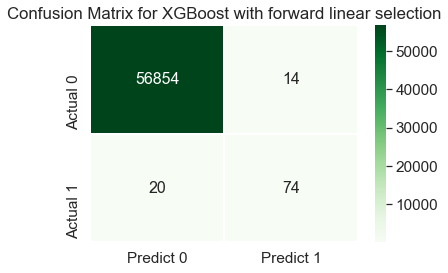

Accuracy: 0.999403110845827
Sensitivity: 0.7872340425531915
Specificity: 0.9997538158542589
Precision: 0.8409090909090909
f1 score: 0.8131868131868133
AUC value is: 0.8934939292037252
Model classification metrics have finished calculating!
Model fitting and results are complete!
Accuracy with all fraud results is 95.9349593495935%


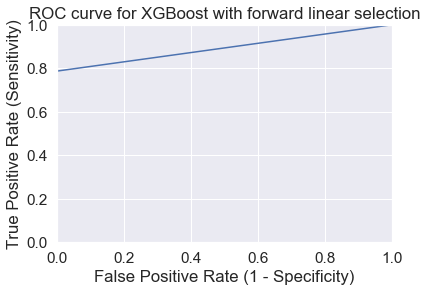

In [15]:
# Using train test split number = 41 for all sampling

# finalcolstouse is list of features that are significant (p < 0.05) for linear regression
# modelpipeline.run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'XGBoost', 'XGBoost with forward linear selection', False)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Oversampling is complete!
[0]	validation_0-error:0.027048	validation_1-error:0.03332
[5]	validation_0-error:0.012141	validation_1-error:0.015344
[10]	validation_0-error:0.006641	validation_1-error:0.009146
[15]	validation_0-error:0.002801	validation_1-error:0.006092
[20]	validation_0-error:0.002238	validation_1-error:0.004582
[25]	validation_0-error:0.001908	validation_1-error:0.003739
[30]	validation_0-error:0.001572	validation_1-error:0.003318
[35]	validation_0-error:0.001211	validation_1-error:0.002897
[40]	validation_0-error:0.001079	validation_1-error:0.002686
[45]	validation_0-error:0.000906	validation_1-error:0.002458
[50]	validation_0-error:0.0008	validation_1-error:0.002019
[55]	validation_0-error:0.000708	validation_1-error:0.001843
[60]	validation_0-error:0.000598	validation_1-error:0.00158
[65]	validation_0-error:0.000481	validation_1-error:0.001422
[70]	validation_0-error:0.000411	validation_1-error:0.001317
[75]	validation_0-error:0.000361	validation_1-error:0.001124
[80]

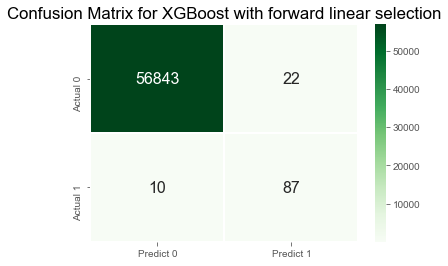

Accuracy: 0.9994382219725431
Sensitivity: 0.8969072164948454
Specificity: 0.9996131187901169
Precision: 0.7981651376146789
f1 score: 0.8446601941747572
AUC value is: 0.9482601676424811
Model classification metrics have finished calculating!
Model fitting and results are complete!
Accuracy with all fraud results is 97.96747967479675%


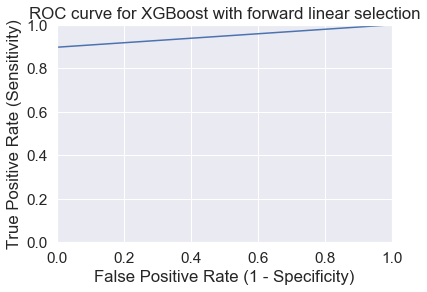

In [5]:
# Using train test split number = 40 for all sampling

# finalcolstouse is list of features that are significant (p < 0.05) for linear regression
# modelpipeline.run_model(self, df, varlist, response, testratio, standardize, sampletype, modelname, text, CV)
results = modelpipeline.run_model(df, finalcolstouse, 'Class', 0.2, True, 'naive', 'XGBoost', 'XGBoost with forward linear selection', False)